In [11]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import random
import matplotlib.pyplot as plt
import math
import regex
import time
import os
from datasets import Dataset
import pickle
from torch.utils.data.dataset import Dataset as torch_Dataset
%run './utils_gpt.ipynb'

In [4]:
device = torch.device("mps:0") if torch.backends.mps.is_available() else torch.device("cpu")
# In macos, using mps:0
# In windows,using cuda
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
if torch.backends.mps.is_available():
    device = torch.device("mps:0") # for MacBook
elif torch.cuda.is_available():
    device = 'cuda'
else :
    device = 'cpu'
print(device)

mps:0


In [5]:
bpe_re = BytePairEncoding()

with open('./vocabulary/bpe_vocab.pkl', 'rb') as f:
    bpe_re.vocab = pickle.load(f)

with open('./vocabulary/bpe_merges.pkl', 'rb') as f:
    bpe_re.merges = pickle.load(f)


In [8]:
train_data_bpere = ShakespeareDataset(mode='train',bpe_re=bpe_re)
val_data_bpere = ShakespeareDataset( mode='val',bpe_re=bpe_re)

--2024-04-17 11:37:01--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
正在解析主机 raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
正在连接 raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... 已连接。
已发出 HTTP 请求，正在等待回应... 200 OK
长度：1115394 (1.1M) [text/plain]
正在保存至: “input.txt.4”

input.txt.4         100%[===================>]   1.06M  2.40MB/s  用时 0.4s      

2024-04-17 11:37:02 (2.40 MB/s) - 已保存 “input.txt.4” [1115394/1115394])



Map (num_proc=8):   0%|          | 0/31497 [00:00<?, ? examples/s]

--2024-04-17 11:37:07--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
正在解析主机 raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
正在连接 raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... 已连接。
已发出 HTTP 请求，正在等待回应... 200 OK
长度：1115394 (1.1M) [text/plain]
正在保存至: “input.txt.5”

input.txt.5         100%[===================>]   1.06M  --.-KB/s  用时 0.1s      

2024-04-17 11:37:07 (9.59 MB/s) - 已保存 “input.txt.5” [1115394/1115394])



Map (num_proc=8):   0%|          | 0/4030 [00:00<?, ? examples/s]

In [17]:
test_data_bpere = ShakespeareDataset( mode='tes%save',bpe_re=bpe_re)

--2024-04-17 15:11:39--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
正在解析主机 raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
正在连接 raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... 已连接。
已发出 HTTP 请求，正在等待回应... 200 OK
长度：1115394 (1.1M) [text/plain]
正在保存至: “input.txt.6”

input.txt.6         100%[===================>]   1.06M  --.-KB/s  用时 0.1s      

2024-04-17 15:11:39 (7.39 MB/s) - 已保存 “input.txt.6” [1115394/1115394])



Map (num_proc=8):   0%|          | 0/4475 [00:00<?, ? examples/s]

In [9]:
# Best hyperparameters
config = {
    'n_embd': 488,
    'n_head': 8,
    'n_layer': 10,
    'block_size': 32,
    'dropout': 0.1,
    'batch_size': 16,
    'learning_rate': 0.0001,
    'vocab_size': 3257
}
model_best, train_losses, val_losses = train_model(config, train_data_bpere, val_data_bpere)
context = torch.zeros((1, 1), dtype=torch.long, device=device)
generated_text = bpe_re.decode(model_best.generate(context, max_new_tokens=2000, block_size=config['block_size'])[0].tolist())
        
print(generated_text)

31.824761 M parameters
step 0: train loss 8.2499, val loss 8.2597
step 100: train loss 7.0122, val loss 7.0516
step 200: train loss 6.7729, val loss 6.8645
step 300: train loss 6.4845, val loss 6.5853
step 400: train loss 6.1758, val loss 6.2994
step 500: train loss 5.9095, val loss 6.0433
step 600: train loss 5.7061, val loss 5.8718
step 700: train loss 5.5170, val loss 5.7314
step 800: train loss 5.3846, val loss 5.6333
step 900: train loss 5.2855, val loss 5.5380
step 1000: train loss 5.1895, val loss 5.4628
step 1100: train loss 5.1143, val loss 5.4015
step 1200: train loss 5.0393, val loss 5.3574
step 1300: train loss 4.9732, val loss 5.2809
step 1400: train loss 4.9237, val loss 5.2507
step 1500: train loss 4.8765, val loss 5.2245
step 1600: train loss 4.8247, val loss 5.1903
step 1700: train loss 4.7864, val loss 5.1847
step 1800: train loss 4.7371, val loss 5.1554
step 1900: train loss 4.7090, val loss 5.1260
step 2000: train loss 4.6881, val loss 5.1203
step 2100: train loss 4

In [12]:
# save the best model
model_dir = './'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
torch.save(model_best.state_dict(), model_dir + './model/Shakespeare_best.pth')

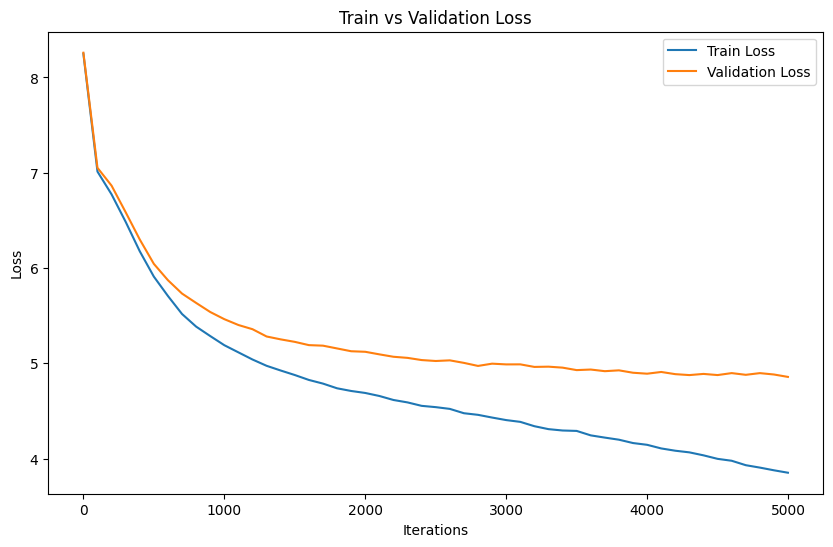

In [13]:
train_steps, train_losses = zip(*train_losses)
val_steps, val_losses = zip(*val_losses)

plt.figure(figsize=(10, 6))
plt.plot(train_steps, train_losses, label='Train Loss')
plt.plot(val_steps, val_losses, label='Validation Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()
plt.show()

In [20]:
# Test on the unseen data

# Evaluate the performance
avg_loss = estimate_loss(model_best , 1000, config['batch_size'], config['block_size'], test_data_bpere)
perplexity = torch.exp(avg_loss)
bpc_bpw = avg_loss / math.log(2)

print(f"Average Loss: {avg_loss:.4f}, BPC/BPW: {bpc_bpw:.4f}, Perplexity: {perplexity:.4f}")


Average Loss: 5.3354, BPC/BPW: 7.6974, Perplexity: 207.5588
